In [2]:
# standard library
import os

# Third-party
from astropy.constants import G
import astropy.coordinates as coord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import corner
from pyia import GaiaData
import pystan
from gala.units import UnitSystem
from scipy.stats import binned_statistic_2d

In [3]:
def sech2_potential(z, sigma, hz, G):
    return 4*np.pi*G * sigma * hz * np.log(np.cosh(0.5 * z / hz))

In [4]:
units = UnitSystem(u.pc, u.Myr, u.radian, u.Msun)

## Prepare data:

In [5]:
allstar = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')
allstar = Table(allstar)

xm = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStar-r12-gaiadr2.fits')
xm_tbl = Table()
for col in ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'apogee_id']:
    xm_tbl[col] = xm[col]
xm_tbl.rename_column('apogee_id', 'APOGEE_ID')

tbl = join(allstar, xm_tbl, keys='APOGEE_ID')
g = GaiaData(tbl)

In [6]:
mask = ((tbl['LOGG'] > 0.) & (tbl['LOGG'] < 3.5) &
        (tbl['TEFF'] > 4000) & (tbl['TEFF'] < 6500) & 
        (tbl['SNR'] > 50) & 
        np.isfinite(tbl['ALPHA_M']) & (tbl['ALPHA_M'] > -999) &
        ((g.parallax / g.parallax_error) > 10) & 
        (g.get_distance(allow_negative=True) < 4*u.kpc))

# HACK:
# mask &= (np.abs(g.ALPHA_M) < 0.125)

mask.sum()

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


121781

In [7]:
galcen_frame = coord.Galactocentric(z_sun=0*u.pc)

In [8]:
sub_g = g[mask]
c = sub_g.get_skycoord(radial_velocity=sub_g.VHELIO_AVG*u.km/u.s)
galcen = c.transform_to(galcen_frame)
elem = np.array(sub_g.ALPHA_M, dtype='f8')

In [9]:
z = galcen.z.decompose(units).value
vz = galcen.v_z.decompose(units).value
G_ = G.decompose(units).value

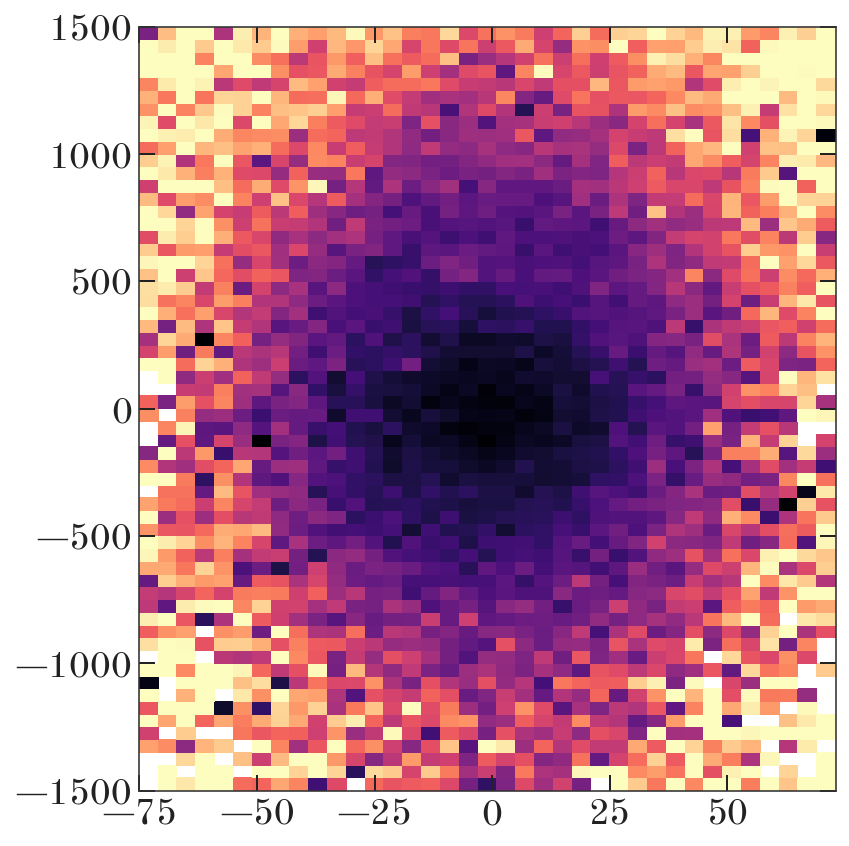

In [10]:
zlim = 1500 # pc
vlim = 75. # pc/Myr
vstep = 4
zstep = 50

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

stat = binned_statistic_2d(vz, z, elem, statistic='mean',
                           bins=(np.arange(-vlim, vlim+1e-3, vstep),
                                 np.arange(-zlim, zlim+1e-3, zstep)))

vmin, vmax = np.percentile(elem, [15, 85])
ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
              cmap='magma', vmin=vmin, vmax=vmax)

fig.tight_layout()

---

In [143]:
sm = pystan.StanModel('../stan/one_trend.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ab6e018c6622737097f22e4d9a0128c NOW.


In [11]:
data = {'z': galcen.z.decompose(units).value,
        'v_z': galcen.v_z.decompose(units).value,
        'elem': elem,
        'n_stars': len(galcen),
        'G': G.decompose(units).value}

In [12]:
init = {'ln_Sigma': np.log(50.),
        'ln_hz': np.log(250.),
        'inv0': 0,
        'a0': 0.,
        'a1': 1e-2,
        'a2': 3e-3}

(-0.4, 0.4)

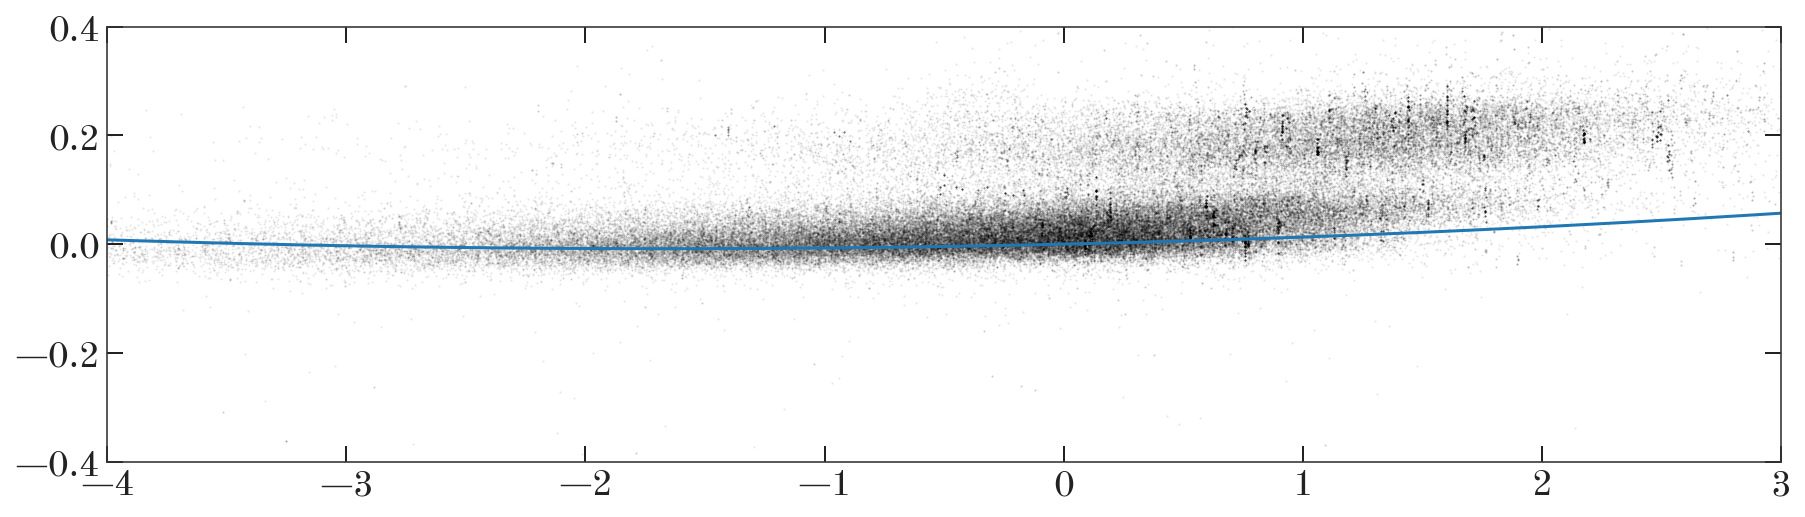

In [13]:
Ez = (0.5*data['v_z']**2 + sech2_potential(data['z'], np.exp(init['ln_Sigma']), 
                                           np.exp(init['ln_hz']), G_))
invariant = np.log(Ez) - np.mean(np.log(Ez))

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.scatter(invariant, elem, 
           alpha=0.1, marker='o', s=1., color='k', linewidth=0)

igrid = np.linspace(-4, 3, 128)
di = igrid - init['inv0']
ax.plot(igrid, init['a0'] + init['a1']*di + init['a2']*di**2, marker='')

ax.set_xlim(-4, 3)
ax.set_ylim(-0.4, 0.4)

In [165]:
fit = sm.optimizing(data, init=init)

In [ ]:
samples = sm.sampling(data, init=[fit], chains=1)

(-0.4, 0.4)

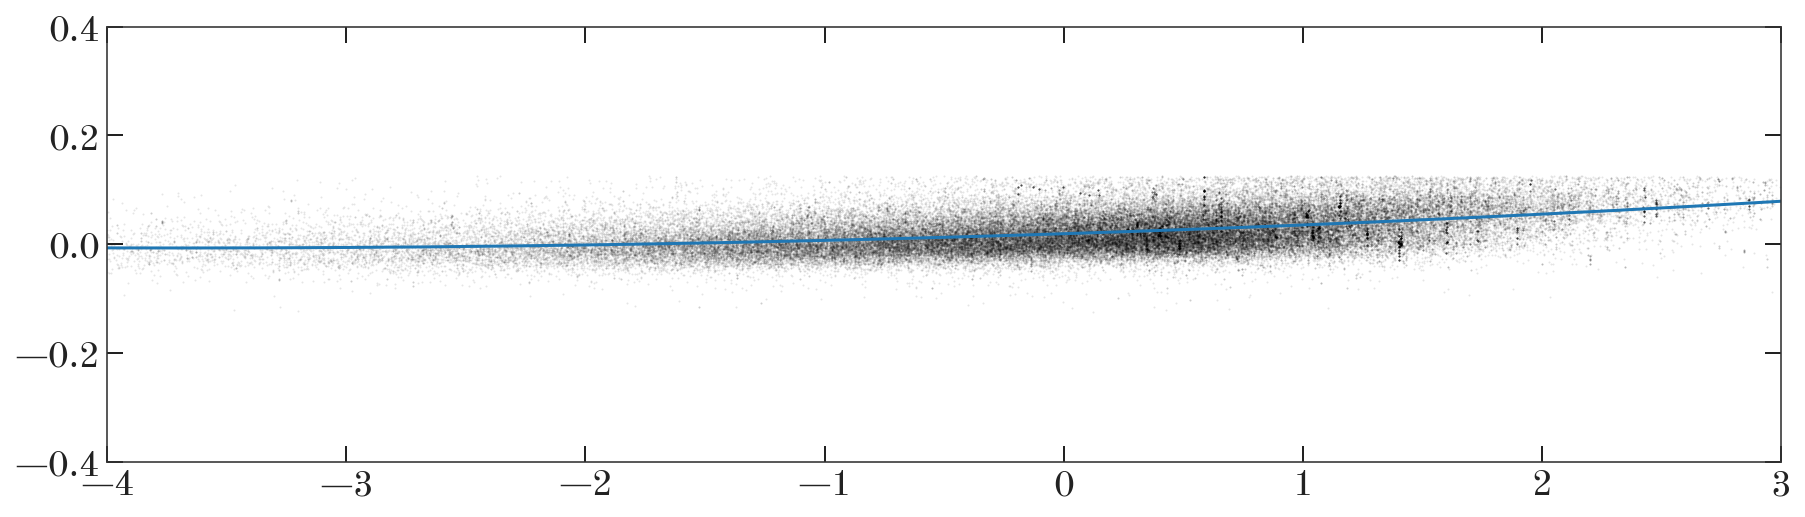

In [167]:
Ez = (0.5*data['v_z']**2 + sech2_potential(data['z'], np.exp(fit['ln_Sigma']), 
                                           np.exp(fit['ln_hz']), G_))
invariant = np.log(Ez) - np.mean(np.log(Ez))

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.scatter(invariant, elem, 
           alpha=0.1, marker='o', s=1., color='k', linewidth=0)

igrid = np.linspace(-4, 3, 128)
di = igrid - fit['inv0']
ax.plot(igrid, fit['a0'] + fit['a1']*di + fit['a2']*di**2, marker='')

ax.set_xlim(-4, 3)
ax.set_ylim(-0.4, 0.4)